# Machine Learning Project
---

### Ali Nazari
##### Spring 2020

## Introduction
There are more than 12 thousand miles of roads and highways in state of Idaho. Idaho Transportation Department (ITD) is in charge maintenance and development of these roads. One of the metrics used evaluating our roads is the annual traffic volume count on these roads. The most common method to collect the traffic count is establish a short-term portable count station. There are more than 50 thousand of these stations in Idaho. It is not possible for ITD to collect data from all these stations every year. The manual task of selecting proper stations at which a field crew collects the traffic count is tedious and time consuming. This project is intended to use Machine Learning algorithms to classify the stations into picked and not picked.

## Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc,pairwise
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
global est_year
est_year = 2019

## Data
The data is gathered from ITD’s public data warehouse. After aggregating the
station data and filtering out valid stations, data is exported as text files. The test
files are used as the input files for this notebook. There are several fairly
independent features assumed for this data set. The categorical features are the
following
[Source](https://www.fhwa.dot.gov/policyinformation/hpms/fieldmanual/page00.cfm):

-   RouteID: The method of stations spatial referencing is Linear Referencing
    System, in which the locations of stations along a linear element are
    described in terms of measurements from a fixed point. Each linear element
    is recognized as a route. The routes are categorized as: OH (Off Highways), SH
    (State Highways), IN (Interstate Highways) and US (US Highways).

-   FuntionalClass: Functional systems result from the grouping of highways by
    the character of service they provide.

    1.  *Interstate*

    2.  *Principal Arterial – Other Freeways and Expressways*

    3.  *Principal Arterial – Other*

    4.  *Minor Arterial*

    5.  *Major Collector*

    6.  *Minor Collector*

    7.  *Local*

-   FacilityType:

	1.  *One-Way Roadway: Roadway that operates with traffic moving in a single
		direction during non-peak period hours.*

	2.  *Two-Way Roadway: Roadway that operates with traffic moving in both
		directions during non-peak period hours.*

	3.  *Ramp: Non-mainline junction or connector facility contained within a
		grade-separated interchange. *

	4.  *Non Mainline: All non-mainline facilities excluding ramps. *

	5.  *Non-Inventory Direction: Individual road/roads of a multi-road facility
		that is/are not used for determining the primary length for the facility. *

	6.  *Planned/Unbuilt: Planned roadway that has yet to be constructed. *

-   Urban: According to definitions in 23 U.S.C. 101(a), areas of population greater than 5,000 qualify as urban for transportation purposes.

-   AADT: Annual Average Daily Traffic (AADT) identifies the average volume of
    traffic for the average one day (24-hour period) during a data reporting
    year at a specific location or specific segment of road.

-   CAADT: Commercial vehicles AADT.

-   RecentYear: Number of years passed since the last count in that station.

-   X_cord and Y_cord: X and Y coordinates of a station.

The above data are the result of merging the following datasets.

-   sta19: The stations selected for collecting data during 2019
-   staLast: The stations along with the year when the most recent count was collected
-   stations: All the valid station for this study excluding the automatic collectors


In [2]:
sta19 = pd.read_csv('data/stations2019.txt', sep='\t')    # 2019 picked stations
staLast = pd.read_csv('data/stationsLast.txt', sep='\t')    # most recent count
stations = pd.read_pickle('data/stations.pkl')    # all valid stations

C:\Users\alina\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,68,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing
### Cleaning Data
In this step, the correct data type is asigned to each feature and the features of interest are filtered out of the data.

In [3]:
# rename columns
sta19.columns = ['StationID', 'Picked']
sta19.drop_duplicates(inplace=True)
staLast.columns = ['StationID', 'RecentYear']
staLast.drop_duplicates(inplace=True)
stations.rename({'CommercialAADT':'CAADT'},axis=1,inplace=True)
stations['RouteID'] = stations['RouteID'].str.strip('0123456789AD')
stations.loc[stations[stations['CAADT']==0].index,'CAADT']=1    # For log transformation

# filter required columns in stations
nominalFt = [
    'RouteID',
    'FacilityType',
    'FunctionalClass',
    'Urban',
]
numCols = [
    'AADT',
    'CAADT',
    'X_cord',
    'Y_cord',
]
staCol = ['StationID']+numCols+nominalFt
stations = stations[staCol]
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32006 entries, 0 to 32005
Data columns (total 9 columns):
StationID          32006 non-null object
AADT               32006 non-null int64
CAADT              32006 non-null int64
X_cord             32006 non-null int64
Y_cord             32006 non-null int64
RouteID            32006 non-null object
FacilityType       32006 non-null int64
FunctionalClass    32006 non-null int64
Urban              32006 non-null int64
dtypes: int64(7), object(2)
memory usage: 2.2+ MB


In [4]:
# merge stations with 2019 stations and most recent counts
stations = stations.merge(staLast,how='left',on='StationID')
stations = stations.merge(sta19,how='left',on='StationID')

# Modify variables
stations['Picked'] = ~stations['Picked'].isna()

stations['RecentYear'] = est_year - stations['RecentYear']
#stations['RecentYear'].fillna(100, inplace=True)    # creates skewed data
stations.dropna(subset=['RecentYear'], inplace=True)
stations['RecentYear'] = stations['RecentYear'].astype('i2')
numCols.append('RecentYear')

stations.set_index('StationID', inplace=True)
stations.head()

,AADT,CAADT,X_cord,Y_cord,RouteID,FacilityType,FunctionalClass,Urban,RecentYear,Picked
StationID,,,,,,,,,,
00000-42248-0-1-0-0,4100,1400,2444565,1199898,US,2,3,0,10,False
00000-36047-0-5-0-0,350,40,2607624,1200838,OH,2,5,0,4,False
00000-16038-0-4-0-0,210,20,2565696,1201362,OH,2,5,0,14,False
00000-36047-0-1-0-0,350,40,2608052,1201479,OH,2,5,0,4,False
00000-16038-0-8-0-0,200,10,2565541,1201643,OH,2,5,0,14,False


### Transform Categorical Features 
The dataset contains two different data types. Numerical and Categorical. Typically, any standard workflow in feature engineering involves some form of transformation of these categorical values into numeric labels and then applying some encoding scheme on these values. There are two major classes of categorical data, nominal and ordinal. In this project I am dealing with purely nominal features ([source](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)). 

In any nominal categorical data attribute, there is no concept of ordering amongst the values of that attribute. In our example the following features are nominal:
    * RouteID
    * Facility Type
    * Functional class
    * Urban
    
Since the data is consists of both numerical and nominal data, the nominal categorical data are transferred to one-hot-encoding features.


In [ ]:
def oheTransfer (ds):
    # tranfer to labels
    le = preprocessing.LabelEncoder()
    arr = le.fit_transform(ds)
    arr = np.expand_dims(arr, axis=1)
    # encode labels using one-hot encoding scheme
    ohe = preprocessing.OneHotEncoder(categories='auto')
    ftArray = ohe.fit_transform(arr).toarray()
    ftLabels = [ds.name+'_'+str(l) for l in ds.unique()]
    return pd.DataFrame(ftArray, columns = ftLabels, index=ds.index)

stations = pd.concat([stations]+[oheTransfer(stations[ft]) for ft in nominalFt], axis=1)
stations.info()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002793A176308>,
      dtype=object)

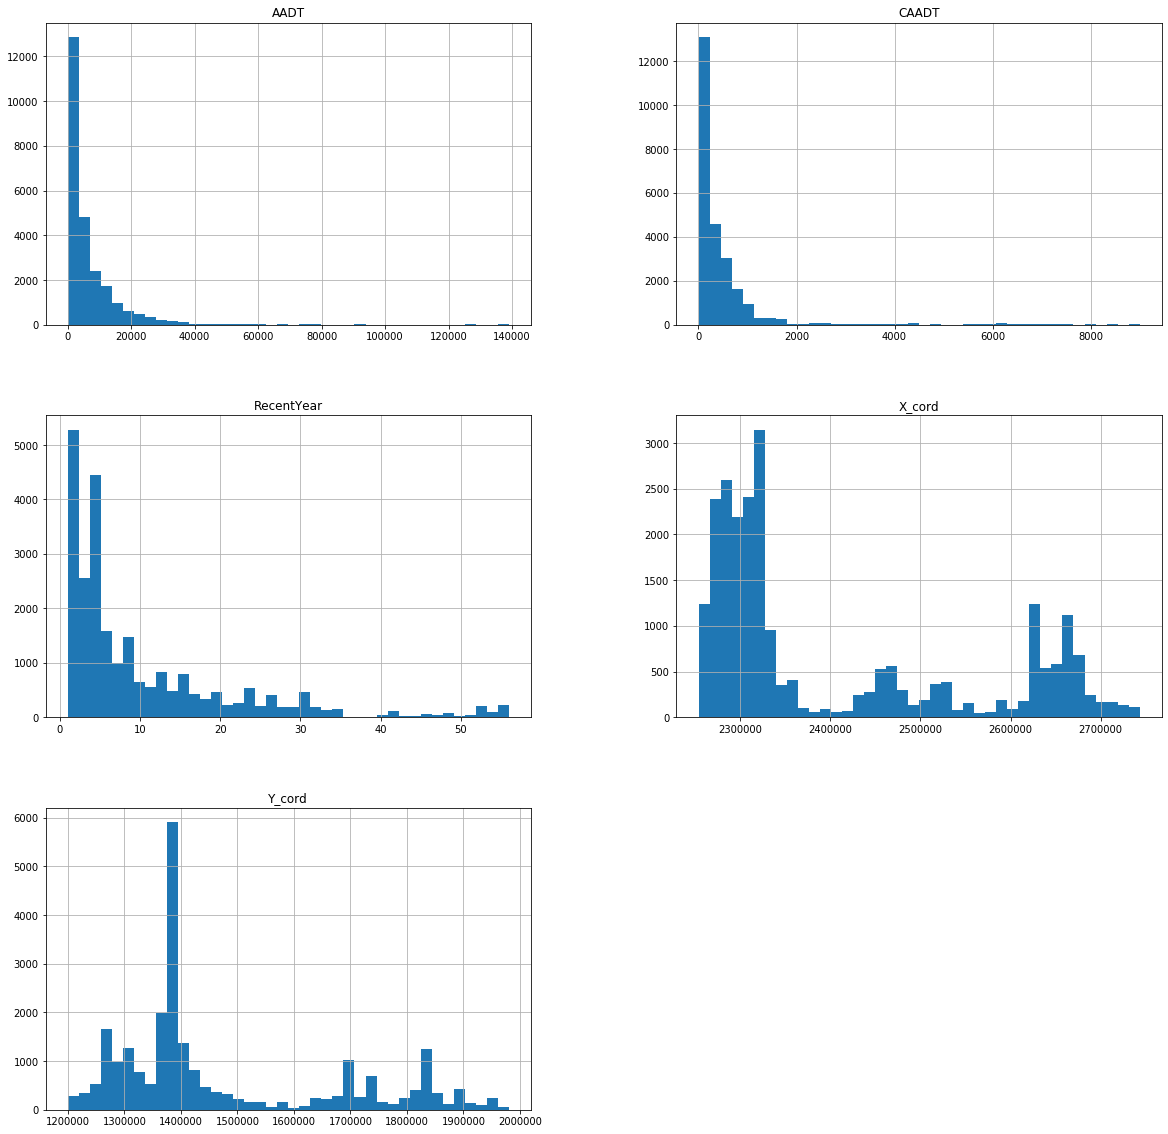

In [6]:
stations[numCols].hist(bins=40, figsize=(20,20))

### Scaling Data 
Often machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. It is observed in the above plot that the variables distributions vary and are highly skewed.

**Log transformation**
I use this method for transforming AADT and CAADT feature to force them closed to normal distribution. It seems that using a log transformation decreased the scale of the distributions. It seems the outliers caused the log-transformed distributions to still be a bit skewed, but it is closer to normal than the original distribution. 

**MinMaxScaler**
Min-Max scaler doesn’t reduce the skewness of a distribution. It simply shifts the distribution to a smaller scale [0–1]. For this reason, it seems Min-Max scaler isn’t the best choice for a distribution with outliers or severe skewness. I am using these methods to scale the Hypergeometric features which are X_cord and Y_cord. I am using this scaler for scaling RcentYear feature as well since it is highly skewed based on the distributions above.

[Source](https://medium.com/@sjacks/feature-transformation-21282d1a3215)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002793A01C5C8>,
      dtype=object)

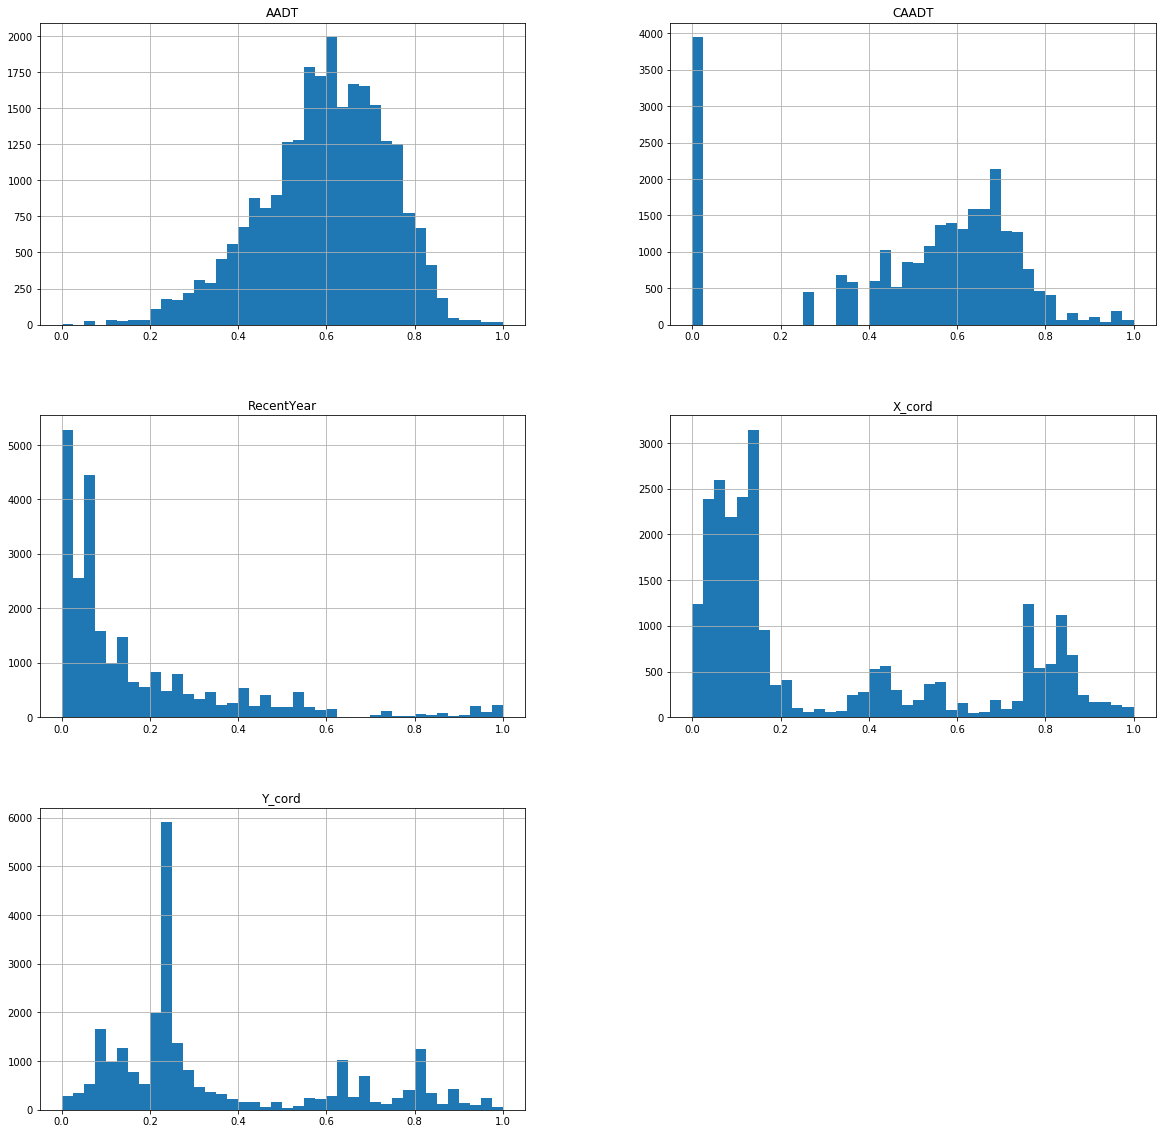

In [7]:
def scale(df):
    scl = MinMaxScaler()
    sclDF = df.copy()
    logCol = ['AADT','CAADT']
    if all(c in df.columns for c in logCol):
        sclDF.loc[:,logCol] = df[logCol].apply(np.log, axis=1)
    return pd.DataFrame(scl.fit_transform(sclDF), index=df.index, columns=df.columns)
scale(stations[numCols]).hist(bins=40, figsize=(20,20))

### Train-Test Split
Since this data is extremely imbalanced, in splitting the data the stratify method is used to make sure the distribution of classed won't be disturbed. The test data is reserved for the last step to check the accuracy of the data.

Random Baseline Accurcy of Test Data: 0.918


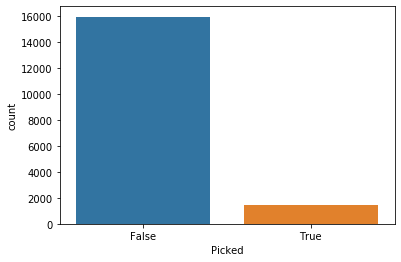

In [8]:
y = stations['Picked']
X = stations.drop(nominalFt+['Picked'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0,
                                                    stratify = y,
                                                   )
global baseline
baseline = (1-y_test.mean())
sns.countplot(x='Picked', data = y_train.to_frame())
print("Random Baseline Accurcy of Test Data: %0.3f"%baseline)

### Balancing Data
The data is strangely imbalance and I need to use a sampling technique to balance the data. The data is imbalance because there are numerous stations in Idaho that are located in rural and remote areas. The abundant of these stations in data are caused the imbalance properties of the data. These stations are seldom selected for data collection because of the scarcity of traffic and difficulty in accessing their location; hence they are classified as *NotPicked*. Several methods to tackle this problem are considered. 
- Under-sample: 
    In this method we are losing data by removing some of data points from the dataset. I use the under-sampling method in order to exclude some of the majority class (NotPicked) in the training data so the results won't be affected by them. Undersampling is efficient and feasible approach for our case since the size of the dataset is large.
- Over-sample: 
    This method will not help to improve our model in this case because it creates only duplications and is not a adding any new information for the model so it can differentiate between classes.
- Synthetic Minority Oversampling Technique (SMOTE)
    This method works when the samples are similar to each other, hence considering their mean as a new data point is reasonable. But if they are not distinct and are spread apart, this method will result in introducing noise to the data by creating data points that might be closer to the majority class. The PCA plot below proves that this is the case for our project.

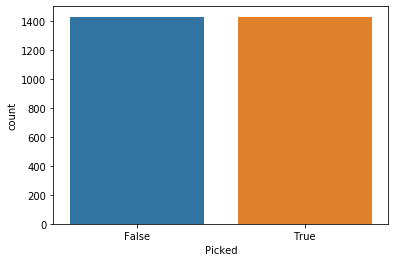

In [9]:
def balance(X_train, y_train):
    # Naive Under Sampling
    
    rus = RandomUnderSampler(random_state=0)
    X, y = rus.fit_resample(X_train, y_train)
    X = pd.DataFrame(X,  columns=X_train.columns)
    y = pd.Series(y, name=y_train.name)
    return X, y
sns.countplot(x = 'Picked', data = balance(X_train, y_train)[1].to_frame())

### PCA Visualization

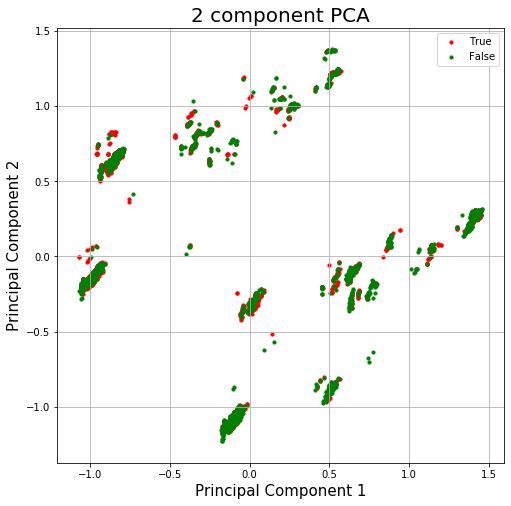

In [10]:
_X, _y = balance(scale(X),y)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index=_X.index)
finalDf = pd.concat([principalDf, _y], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g']
targets = [True, False]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Picked'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_

The above plot suggests that the highest two components are not enough to explain the variance and there are no few dominant features than can be used to linearly separate the data. There is no dominant feature among the independent variables that would explain more than 50% of the variance. The features might not be quite independent. Also, This suggests that the dependency between independent variables (predictors) and the dependent variable (prediction) is not strong.

## Model Selection
I am looking at four different classification tools and their performance.
    * Logistic Regression
    * ComplementNB
    * DecisionTreeClassifier
    * SVC
    
Logistic Regression is chosen as the basic linear model to observe its performance against the non-linear separable data. Logistic Regression Model is binary classification model that often is used as a baseline due to its simple performance. 

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of P(x_i \mid y). ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB.

Decision Trees (DTs) are a non-parametric supervised learning method used for classification. Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed. Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

SVC is a strong classification model and when used with rbf kernel can perform nonlinear classifications with high performance.

### Parameters
I construct a dictionary of possible parameters for each model and then use gridsearch to find the best set of parameters based on the accuracy they return.

In [11]:
# define a parameters grid for each model
gridLogis = { 'solver':['lbfgs']}
gridNB={
    'alpha': np.power(10,np.linspace(0,7,8)),
    'norm': [0,1]
}
gridTree={
    'splitter': ['best', 'random'],
    'max_depth': np.linspace(3,18,6),
    'max_features': ['auto', 'sqrt','log2',None],
}
gridSVC = {
    'C': np.power(10,np.linspace(-1,4,6)),
    #'C': [1,10],
    'gamma': ['scale','auto'],
    #'gamma': ['scale'],
    'kernel': ['rbf','sigmoid']
}

In [12]:
estimator_ = {
    'Logis': LogisticRegression,
    'NB':ComplementNB,
    'Tree': DecisionTreeClassifier,
    'SVC': SVC,
}
param={
    'Logis': gridLogis,
    'NB': gridNB,
    'Tree': gridTree,
    'SVC': gridSVC,
}

### Analysis functions

In [13]:
def plot_roc_curve(y_test, y_score):
    '''Plots a roc curve including a baseline'''
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating curve')
    plt.legend(loc="lower right")
    plt.show()
    print('-----------------------------------------------\n')

def reportclassfication(clf, X_test, y_test):
    '''Reports classification results with the given model and testdata'''
    
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Confusion matrix")
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, columns = ["Pred_Picked","Pred_notPicked"],index=["Picked","NotPicked"])
    print(cm)
    print("\nDetailed classification report:")
    print(classification_report(y_true, y_pred, digits=5))

def Y_Score(clf, X, est):
    if est in ['Logis','SVC']:
        return clf.decision_function(X)
    elif est in ['Tree','NB']:
        return clf.predict(X)

### Train Model

#### No Scaling or Balancing

In [14]:
model={}
for e in estimator_:
    clfName = estimator_[e].__name__
    # create the datasets
    train_X = X_train.copy()
    train_y = y_train.copy()
    test_X = X_test.copy()
    test_y = y_test.copy()

    # select best parametrs
    grid = GridSearchCV(estimator_[e](), param[e], cv=3, return_train_score=False)
    grid.fit(train_X,train_y)
    model[clfName] = grid.best_params_
    print("The best parameters for %s are %s with a score of %0.4f"
          % (clfName, grid.best_params_, grid.best_score_))
    # test the model
    clf = estimator_[e](**model[clfName] )
    clf.fit(train_X,train_y)
    print("Test Score: %0.4f\n"%clf.score(test_X, test_y))

The best parameters for LogisticRegression are {'solver': 'lbfgs'} with a score of 0.9175
Test Score: 0.9175

The best parameters for ComplementNB are {'alpha': 10.0, 'norm': 1} with a score of 0.9175
Test Score: 0.9175

The best parameters for DecisionTreeClassifier are {'max_depth': 3.0, 'max_features': 'log2', 'splitter': 'best'} with a score of 0.9177
Test Score: 0.9175

The best parameters for SVC are {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'} with a score of 0.9268
Test Score: 0.9281



##### Results

Running the four models on the testing data without scaling or balancing the data resulted in accuracy which are mainly less than the baseline (91.8%) except for the SVC. This show the power of support vector machine with rbf kernel. Since I have 20 features in this task which are probabely have some degree of dependency, rbf does a great job transfering the data into the higher dimensions and classifying them.

#### With Scaling and Balancing

Accuracy is not a reliable performance metric when working with highly imbalanced data. The focus of this project is to predict the stations which are *picked* for data collection. In other words, the question is What proportion of actual positives (picked stations) was predicted correctly?

To answer to this question, I need to look at the True Positive Rate (i.e. Recall). For this purpose, I balanced and scaled the data and then run the models and look at the R.O.C curve and classification report and confusion matrix. ROC answers the question: "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?" which precision and recall don't.

The best parameters for LogisticRegression are {'solver': 'lbfgs'} with a score of 0.6473
Confusion matrix
           Pred_Picked  Pred_notPicked
Picked            4252            2578
NotPicked          205             409

Detailed classification report:
              precision    recall  f1-score   support

       False    0.95400   0.62255   0.75343      6830
        True    0.13693   0.66612   0.22716       614

    accuracy                        0.62614      7444
   macro avg    0.54547   0.64434   0.49030      7444
weighted avg    0.88661   0.62614   0.71002      7444



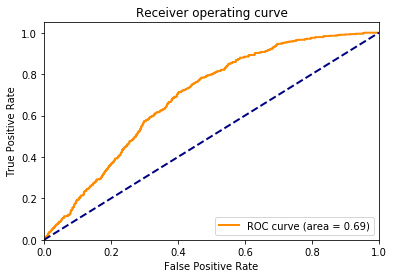

-----------------------------------------------

The best parameters for ComplementNB are {'alpha': 100.0, 'norm': 1} with a score of 0.6096
Confusion matrix
           Pred_Picked  Pred_notPicked
Picked            3925            2905
NotPicked          235             379

Detailed classification report:
              precision    recall  f1-score   support

       False    0.94351   0.57467   0.71429      6830
        True    0.11541   0.61726   0.19446       614

    accuracy                        0.57818      7444
   macro avg    0.52946   0.59597   0.45437      7444
weighted avg    0.87521   0.57818   0.67141      7444



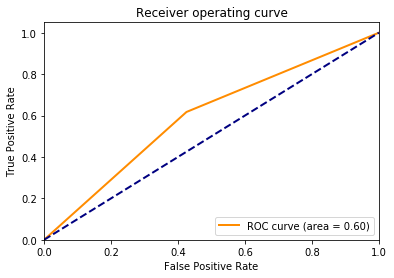

-----------------------------------------------

The best parameters for DecisionTreeClassifier are {'max_depth': 12.0, 'max_features': None, 'splitter': 'best'} with a score of 0.7727
Confusion matrix
           Pred_Picked  Pred_notPicked
Picked            4776            2054
NotPicked          125             489

Detailed classification report:
              precision    recall  f1-score   support

       False    0.97450   0.69927   0.81425      6830
        True    0.19229   0.79642   0.30979       614

    accuracy                        0.70728      7444
   macro avg    0.58339   0.74784   0.56202      7444
weighted avg    0.90998   0.70728   0.77264      7444



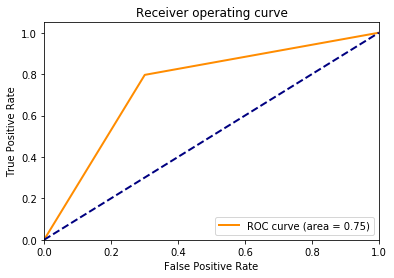

-----------------------------------------------

The best parameters for SVC are {'C': 10000.0, 'gamma': 'scale', 'kernel': 'rbf'} with a score of 0.7263
Confusion matrix
           Pred_Picked  Pred_notPicked
Picked            4558            2272
NotPicked          107             507

Detailed classification report:
              precision    recall  f1-score   support

       False    0.97706   0.66735   0.79304      6830
        True    0.18244   0.82573   0.29885       614

    accuracy                        0.68041      7444
   macro avg    0.57975   0.74654   0.54595      7444
weighted avg    0.91152   0.68041   0.75228      7444



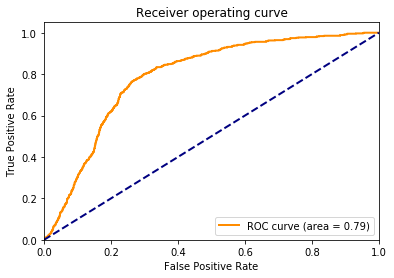

-----------------------------------------------



In [15]:
param_best={}
for e in estimator_:
    clfName = estimator_[e].__name__
    # create the datasets
    train_X, train_y = balance(scale(X_train), y_train)
    test_X = scale(X_test)
    test_y = y_test.copy()
    
    # select best parametrs
    grid = GridSearchCV(estimator_[e](), param[e], cv=3, return_train_score=False)
    grid.fit(train_X,train_y)
    param_best[e] = grid.best_params_
    print("The best parameters for %s are %s with a score of %0.4f"
          % (clfName, grid.best_params_, grid.best_score_))
    # test the param_best
    clf = estimator_[e](**grid.best_params_ )
    clf.fit(train_X,train_y)   
    reportclassfication(clf, test_X, test_y)
    scores_y = Y_Score(clf, test_X, e)
    plot_roc_curve(test_y, scores_y)

##### Results

We are looking to catch as many picked stations as possible and reduce any false negative (predicting negative when it should have been positive) hence we are looking for recall. All the above models are performing well considering the recall rate and f-1 score. The diagonal elements of confusion matrix are larger than their adjacent numbers which means the predictions are fairly matching the ground truth.

For this project the proportion of actual positives compare to correct predictions is important, hence the recall for True is the main metric. The logistic regression model as baseline is scoring 0.67 for recall. Compare to this base line the highest recall is achieved by SVC model for imbalanced testing data which is 82.3%. Looking at R.O.C curve shows the SVC model has gained the largest area. The evaluation of the test depends on how well the test separates the group being tested into *picked* and *notPicked*. The evaluation is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents a worthless test.


### Train Best Model

Looking at the above results it turns out the SVC model is performing better the the other models. Hence I proceed with a k-old cross validation to make sure I am not overfitting the model itself. The train data is splited into 3 validation splits using stratifiedkFold. The data is balanaced and scaled. 

Using the best parameter results of above analysis, The model is fit into each split.

In [16]:
skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=False)
_X, _y = balance(X_train, y_train)
result=[]    # stores acc for each fold 
for train_index, valid_index in skf.split(_X, _y):
    train_X, valid_X = _X.iloc[train_index,:], _X.iloc[valid_index,:]
    train_y, valid_y = _y.iloc[train_index], _y.iloc[valid_index]
    train_X = scale(train_X)
    valid_X = scale(valid_X)
    
    clf = SVC(**param_best['SVC'])
    clf.fit(train_X, train_y)
    reportclassfication(clf, valid_X, valid_y)
    print("-----------------------------------\n")

Confusion matrix
           Pred_Picked  Pred_notPicked
Picked             316             162
NotPicked          101             377

Detailed classification report:
              precision    recall  f1-score   support

       False    0.75779   0.66109   0.70615       478
        True    0.69944   0.78870   0.74140       478

    accuracy                        0.72490       956
   macro avg    0.72862   0.72490   0.72377       956
weighted avg    0.72862   0.72490   0.72377       956

-----------------------------------

Confusion matrix
           Pred_Picked  Pred_notPicked
Picked             320             157
NotPicked           93             384

Detailed classification report:
              precision    recall  f1-score   support

       False    0.77482   0.67086   0.71910       477
        True    0.70980   0.80503   0.75442       477

    accuracy                        0.73795       954
   macro avg    0.74231   0.73795   0.73676       954
weighted avg    0.74231   0.73

Considering the Recall metric for True value, the model performce fairly consistant ranging from 76% to 81%. Last step is to fit the model to the testing data. 

### Test Best Model
Using the best paramets from above analysis and the SVC model, the performace of the model on test data is examined.

Confusion matrix
           Pred_Picked  Pred_notPicked
Picked            4273            2557
NotPicked          100             514

Detailed classification report:
              precision    recall  f1-score   support

       False    0.97713   0.62562   0.76283      6830
        True    0.16737   0.83713   0.27897       614

    accuracy                        0.64307      7444
   macro avg    0.57225   0.73138   0.52090      7444
weighted avg    0.91034   0.64307   0.72292      7444



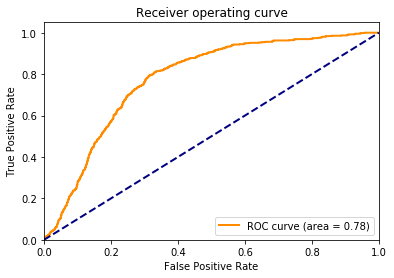

-----------------------------------------------



In [17]:
test_X = scale(X_test)
test_y = y_test.copy()
clf = SVC(**param_best['SVC'])
clf.fit(scale(_X), _y)
scores_y = Y_Score(clf, test_X, 'SVC')
reportclassfication(clf, test_X, test_y)
plot_roc_curve(test_y, scores_y)

## Conclusion
This project attempts to tackle a binary classification task with both categorical and numerical features. The results show that among four different classification algorithms (Naive Bayes, Decision Tree, Logistic Regression and Support Vector Classifier) the SVC out-performed other methods. 

This task main goal was to identify the traffic volume count stations on Idaho which are likely to get selected for data collection based on the characteristics of the road where the stations are located and their location. This task focus is on identifying the True class meaning the stations that need to get selected rather than stations that are getting selected. The reason is the fact that through state of Idaho there are lots of stations in rural areas which are critical. This explains why the metric to evaluate the models against each other was selected to be True Positive Rate and the area under R.O.C. 

The main challenge is this task is combining these two types of data. Using one hot encoder I was able to transform the categorical data into binary features, but the classifiers are often do a better job when they are working with either discrete binary features or continuous features. To improve the models is to modify the continuous variables into categorical variables based on the technical literature. Using all binary features would allow us to utilize classifiers that performed well with binary features such as Bernoulli Naive Bayes classifier instead of Complement Naive Bayes classifier.

A more in-depth data science study needs to be performed to show the independency of the features. It is possible that some of the categorical feature might not be quite independent and this causes a large bias in the classification task.

Since this data is extremely imbalance, another method to improve the task is to define class weight for out classifiers and make up for the unbalance data rather than using random under sampling and over sampling.

Two features in the data had Hypergeometric distributions. I could not find a proper encoding schema to scale these features hence I used Min-Max scaling technique. These two features are not able to be transformed to categorical features because they are representing the coordinates of statins. These two features need either be removed or mapped to municipals and then those municipals get transformed into categorical data.
